In [2]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
from cryptocmd import CmcScraper

start_date = "31-03-2020"
end_date = "31-03-2022"
symbol = "BTC"

In [4]:
df = CmcScraper(symbol, start_date=start_date, end_date=end_date).get_dataframe().set_index("Date").sort_index(0)
df = df.reset_index()

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_6604\29342291.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = CmcScraper(symbol, start_date=start_date, end_date=end_date).get_dataframe().set_index("Date").sort_index(0)


In [5]:
df.dropna(inplace=True)
df = df.reset_index().drop('index', axis=1)
date = pd.to_datetime(df.pop('Date'))

In [6]:
np.asarray([ df.T[i] for i in range(len(df)) ]).shape

(731, 9)

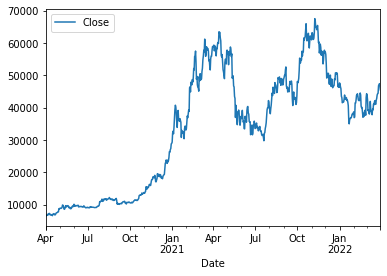

In [7]:
plot_cols = ['Close',]
plot_features = df[plot_cols]
plot_features.index = date
_ = plot_features.plot(subplots=True)

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,731.0,3.326860e+04,1.833954e+04,6.430607e+03,1.163341e+04,3.714926e+04,4.779085e+04,6.754974e+04
High,731.0,3.415735e+04,1.881201e+04,6.504515e+03,1.179559e+04,3.840626e+04,4.917505e+04,6.878963e+04
Low,731.0,3.229453e+04,1.776967e+04,6.202374e+03,1.140844e+04,3.571772e+04,4.674815e+04,6.638206e+04
Close,731.0,3.331605e+04,1.831175e+04,6.438645e+03,1.167029e+04,3.729657e+04,4.774742e+04,6.756683e+04
Volume,731.0,3.892027e+10,2.101295e+10,1.225260e+10,2.603060e+10,3.436356e+10,4.684843e+10,3.509679e+11
Market Cap,731.0,6.246933e+11,3.457258e+11,1.178141e+11,2.154652e+11,6.995161e+11,9.004556e+11,1.274831e+12
Percent Change,731.0,1.003243e+00,3.694726e-02,8.616244e-01,9.852442e-01,1.002561e+00,1.020935e+00,1.187972e+00
Moving,731.0,5.376197e-01,4.989241e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Varince,731.0,1.862824e+03,1.666984e+03,7.676101e+01,4.908531e+02,1.567142e+03,2.636670e+03,1.286462e+04


In [9]:
selected_feature = ["Close",]
target = "Close"

column_indices = {name: i for i, name in enumerate(df.columns)}

split_portion = (0.6, 0.20)

n = len(df)
train_df = df[selected_feature][: int(n * split_portion[0])]
val_df = df[selected_feature][int(n * split_portion[0]) : -int(n * split_portion[-1])]
test_df = df[selected_feature][-int(n * split_portion[-1]) :]

num_features = df[selected_feature].shape[1]

train_df.shape, val_df.shape, test_df.shape, num_features

((438, 1), (147, 1), (146, 1), 1)

In [10]:
train_df.reset_index().drop("index", axis=1).T[0]

Close    6438.644766
Name: 0, dtype: float64

In [11]:
class StandardScaler():
    
    def fit(self, fit_data):
        self.fit_data = fit_data
        self.fit_mean = fit_data.mean()
        self.fit_std = fit_data.std()
        
    def transform(self, data):
        return (data - self.fit_mean) / self.fit_std
    
    def inverse_transform(self, trans_data):
        return trans_data * self.fit_std + self.fit_std
    
    def fit_transform(self, fit_data):
        self.fit(fit_data)
        return self.transform(fit_data)

In [12]:
class MinMaxScaler():
    
    def __init__(self, scale_range=(0, 1)):
        self.a, self.b = scale_range
    
    def fit(self, fit_data):
        self.fit_data = fit_data
        self.fit_min = fit_data.min()
        self.fit_max = fit_data.max()
        
    def transform(self, data):
        return self.a + ((data - self.fit_min)*(self.b - self.a)) / (self.fit_max - self.fit_min)
    
    def inverse_transform(self, trans_data):
        return (trans_data - self.a) * (self.fit_max - self.fit_min) / ((trans_data - self.fit_min)*(self.b - self.a))
    
    def fit_transform(self, fit_data):
        self.fit(fit_data)
        return self.transform(fit_data)

In [13]:
scale_range = train_df.max() - train_df.min()
scale_range["Close"]

57064.81316382

In [14]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

train_df = scaler.fit_transform(train_df)
val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

In [15]:
train_df

,Close
0,0.000000
1,0.002946
2,0.006221
3,0.005165
4,0.007516
...,...
433,0.475285
434,0.473742
435,0.541603
436,0.530344


In [20]:

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from window import WindowGenerator

WIDTH = 30
OFFSET = 2

wide_window = WindowGenerator(
    train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=WIDTH, label_width=WIDTH, shift=OFFSET,
    label_columns=[target]
)
wide_window

Window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
Label column name(s): ['Close']

In [21]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10, max_epochs=MAX_EPOCHS):
    # early_stopping = tf.keras.callbacks.EarlyStopping(
    #     monitor='val_loss', patience=patience, mode='min'
    # )
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val,
                        # callbacks=[early_stopping]
                        )
    
    return history

In [22]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(12, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [23]:
print(f'Input shape: {wide_window.example[0].shape}')
print(f'Output shape: {lstm_model(wide_window.example[0]).shape}')

Input shape: (30, 30, 1)
Output shape: (30, 30, 1)


In [24]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance = lstm_model.evaluate(wide_window.val)
performance = lstm_model.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_absolute_error: 0.0365


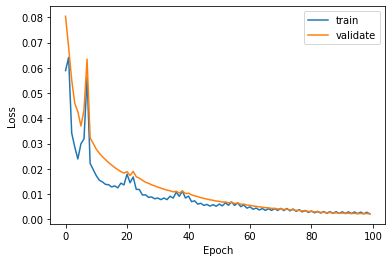

In [25]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history['val_loss'], label="validate")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

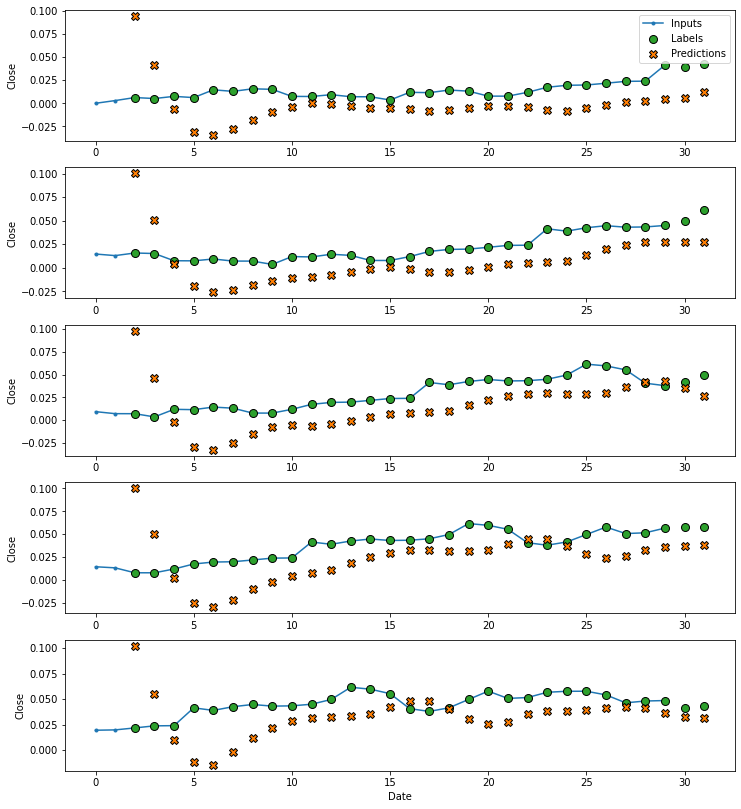

In [26]:
wide_window.plot(plot_col=target, model=lstm_model, max_subplots=5)

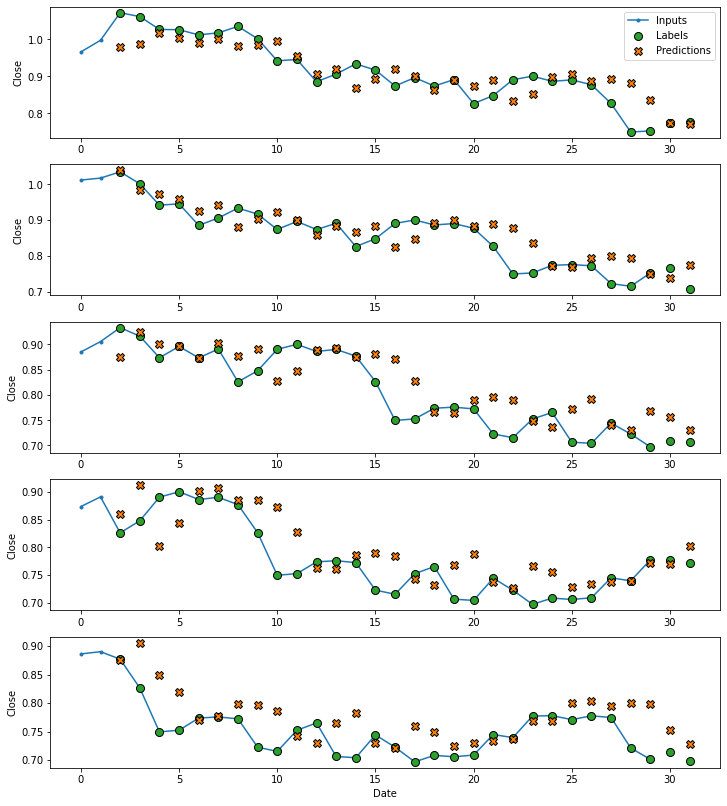

In [27]:
wide_window.plot(plot_col=target, model=lstm_model, example=wide_window.test, max_subplots=5)

In [28]:
print('Validation Loss')
print(f'MSE: {val_performance[0]}, MAE: {val_performance[1]}')
print('Test Loss')
print(f'MSE: {performance[0]}, MAE: {performance[1]}')

Validation Loss
MSE: 0.0021595158614218235, MAE: 0.036523666232824326
Test Loss
MSE: 0.002495367545634508, MAE: 0.03940834105014801


In [29]:
(val_performance[1] * scale_range)["Close"], (performance[1] * scale_range)["Close"]

(2084.2161896338416, 2248.829619122794)

Window size: 44
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Label column name(s): None

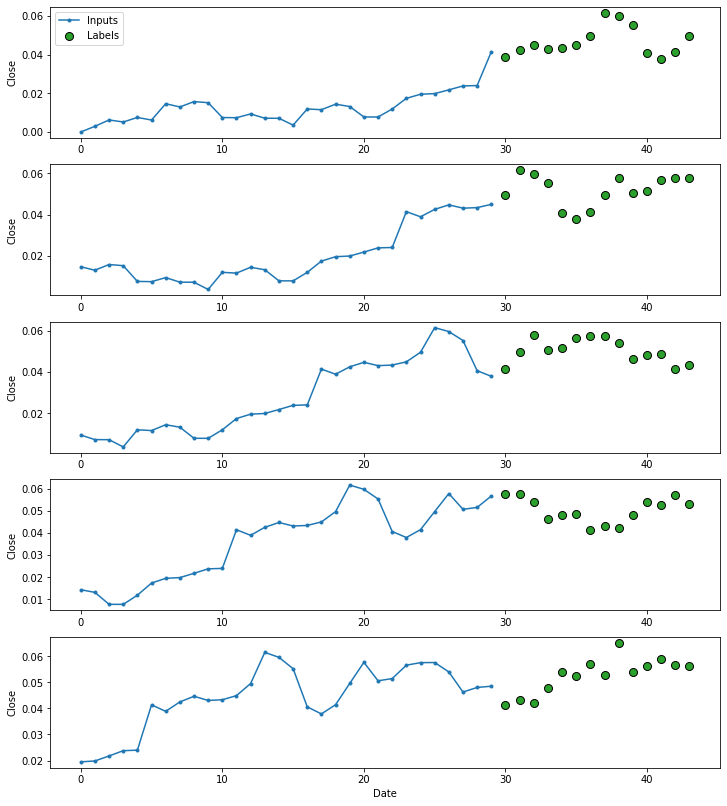

In [30]:
OUT_STEPS = 14
muti_window = WindowGenerator(
    test_df=test_df, val_df=val_df, train_df=train_df,
    input_width=30,
    label_width=OUT_STEPS,
    shift=OUT_STEPS
)
muti_window.plot(plot_col=target, max_subplots=5)
muti_window

In [31]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(12, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

print(f'Input shape: {muti_window.example[0].shape}')
print(f'Output shape: {multi_lstm_model(muti_window.example[0]).shape}')

Input shape: (30, 30, 1)
Output shape: (30, 14, 1)


4/4 [==============================] - 0s 6ms/step - loss: 0.0081 - mean_absolute_error: 0.0727


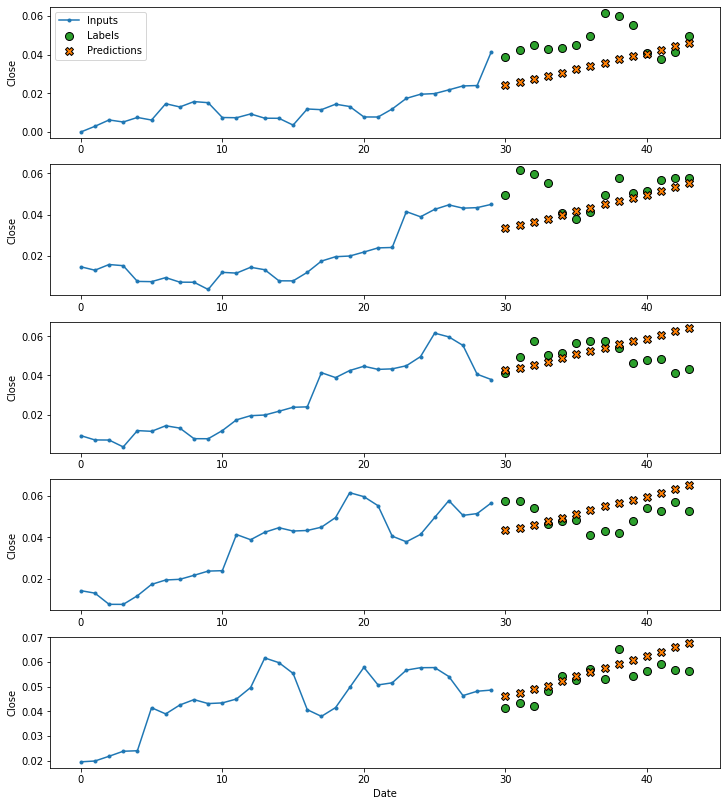

In [32]:
history = compile_and_fit(multi_lstm_model, muti_window)

IPython.display.clear_output()
multi_val_performance = multi_lstm_model.evaluate(muti_window.val)
multi_performance = multi_lstm_model.evaluate(muti_window.test, verbose=0)
muti_window.plot(plot_col=target, model=multi_lstm_model, max_subplots=5)

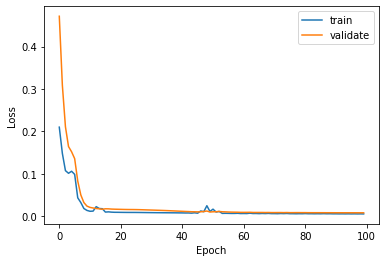

In [33]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history['val_loss'], label="validate")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

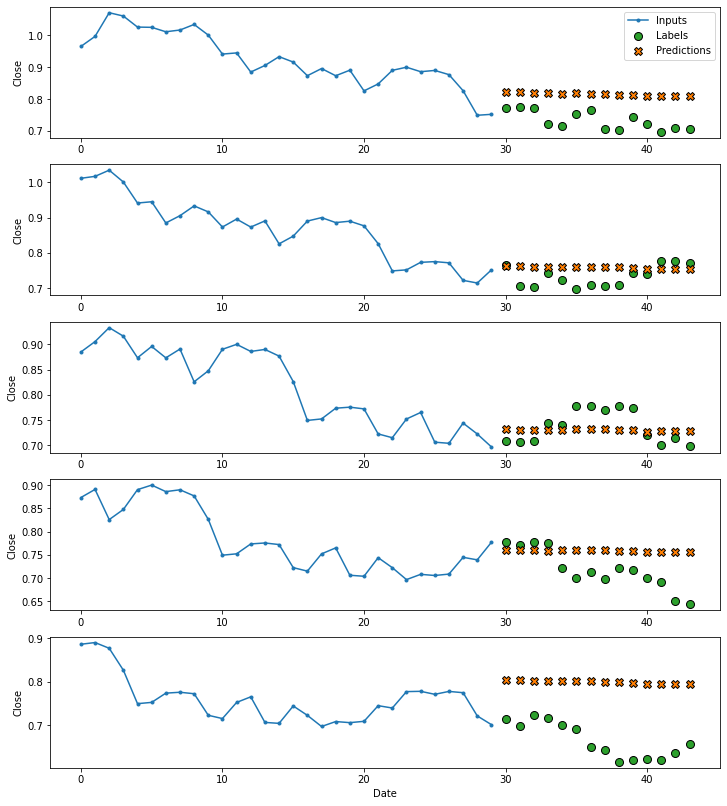

In [34]:
muti_window.plot(plot_col=target, example=muti_window.test, model=multi_lstm_model, max_subplots=5)

In [35]:
print("Validation")
print(f'Loss: {multi_val_performance[0]}, MAE: {multi_val_performance[1]}')
print("Test")
print(f'Loss: {multi_performance[0]}, MAE: {multi_performance[1]}')

Validation
Loss: 0.008133159019052982, MAE: 0.07270734757184982
Test
Loss: 0.008932334370911121, MAE: 0.07900964468717575


In [36]:
(multi_val_performance[1] * scale_range)["Close"], (multi_performance[1] * scale_range)["Close"]

(4149.031204824531, 4508.670612213487)